In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, classification_report
import lightgbm as lgb
from sklearn.decomposition import PCA

# path
path_dir = 'C:/Users/USER/.kaggle/competitions/ieee-fraud-detection/'
file_list = os.listdir(path_dir)
file_list

['sample_submission.csv',
 'test_identity.csv',
 'test_transaction.csv',
 'train_identity.csv',
 'train_transaction.csv']

## Load Data
Load identity.csv and transaction.csv

In [2]:
# Train Data
train_identity = pd.read_csv(path_dir+'train_identity.csv')
train_transaction = pd.read_csv(path_dir+'train_transaction.csv')
# Test Data
test_identity = pd.read_csv(path_dir+'test_identity.csv')
test_transaction = pd.read_csv(path_dir+'test_transaction.csv')

In [3]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [4]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Data Merge
Merge identity data and transaction data on 'TransactionID' column. 

In [5]:
train_merge = pd.merge(train_identity, train_transaction, on=['TransactionID'], how='right')
test_merge = pd.merge(test_identity, test_transaction, on=['TransactionID'], how='right')
train_merge = train_merge.drop(['DeviceInfo'], axis=1)
test_merge = test_merge.drop(['DeviceInfo'], axis=1)

del train_identity, train_transaction, test_identity, test_transaction

In [6]:
train_merge.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Check Null ratio
check null ratio by column and drop columns with null ratio >= 0.77

In [7]:
# Check NULL ratio >= 0.77
check_null = train_merge.isna().sum() / len(train_merge)
check_null[check_null >= 0.77]

id_03    0.887689
id_04    0.887689
id_07    0.991271
id_08    0.991271
id_09    0.873123
           ...   
V335     0.860550
V336     0.860550
V337     0.860550
V338     0.860550
V339     0.860550
Length: 122, dtype: float64

In [8]:
# remove cols of null ratio >= 0.77
remove_cols = list(check_null[check_null >= 0.77].keys())
not_remove_cols = ['id_30','id_31','R_emaildomain','P_emaildomain','ProductCD','card4','card6','DeviceType']

for col in not_remove_cols:
    if col in remove_cols:
        remove_cols.remove(col)
    else:
        pass

train_merge = train_merge.drop(remove_cols, axis=1)
test_merge = test_merge.drop(remove_cols, axis=1)
print(train_merge.shape)
print(test_merge.shape)

(590540, 312)
(506691, 311)


In [9]:
train_merge.head()

,TransactionID,id_01,id_02,id_05,id_06,id_11,id_12,id_15,id_17,id_19,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987004,0.0,70787.0,NaN,NaN,100.0,NotFound,New,166.0,542.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,2987008,-5.0,98945.0,0.0,-5.0,100.0,NotFound,New,166.0,621.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
2,2987010,-5.0,191631.0,0.0,0.0,100.0,NotFound,Found,121.0,410.0,...,90.327904,90.327904,90.327904,90.327904,0.0,0.0,0.0,75.887497,75.887497,75.887497
3,2987011,-5.0,221832.0,0.0,-6.0,100.0,NotFound,New,225.0,176.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,2987016,0.0,7460.0,1.0,0.0,100.0,NotFound,Found,166.0,529.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000


### Fill Na by column type

In [10]:
# select types
object_cols = train_merge.select_dtypes(include='object').columns
nobject_cols = train_merge.select_dtypes(exclude='object').columns

print('Columns of Object Type\n{}'.format(object_cols.values))

Columns of Object Type
['id_12' 'id_15' 'id_28' 'id_29' 'id_30' 'id_31' 'id_35' 'id_36' 'id_37'
 'id_38' 'DeviceType' 'ProductCD' 'card4' 'card6' 'P_emaildomain'
 'R_emaildomain' 'M1' 'M2' 'M3' 'M4' 'M5' 'M6' 'M7' 'M8' 'M9']


In [11]:
train_merge[object_cols] = train_merge[object_cols].fillna('NaN')
train_merge[nobject_cols] = train_merge[nobject_cols].fillna(0)

test_merge[object_cols] = test_merge[object_cols].fillna('NaN')
nobject_cols = list(nobject_cols)
nobject_cols.remove('isFraud')
test_merge[nobject_cols] = test_merge[nobject_cols].fillna(0)

In [12]:
train_merge.head()

,TransactionID,id_01,id_02,id_05,id_06,id_11,id_12,id_15,id_17,id_19,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987004,0.0,70787.0,0.0,0.0,100.0,NotFound,New,166.0,542.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,2987008,-5.0,98945.0,0.0,-5.0,100.0,NotFound,New,166.0,621.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
2,2987010,-5.0,191631.0,0.0,0.0,100.0,NotFound,Found,121.0,410.0,...,90.327904,90.327904,90.327904,90.327904,0.0,0.0,0.0,75.887497,75.887497,75.887497
3,2987011,-5.0,221832.0,0.0,-6.0,100.0,NotFound,New,225.0,176.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,2987016,0.0,7460.0,1.0,0.0,100.0,NotFound,Found,166.0,529.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000


## EDA
- Ratio of isFraud by column
- Distribution of TransactionAmt by isFraud
- Distribution of TransactionAmt by DeviceType

#### Ratio of isFraud by column

Ratio of isFraud 0 : 96.5 %
Ratio of isFraud 1 : 3.5 %


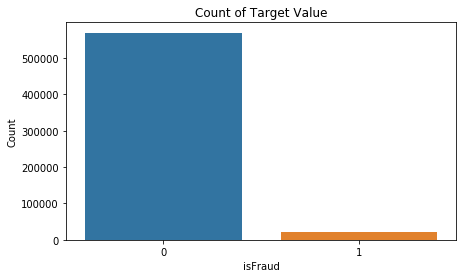

In [13]:
# Ratio of isFraud(target value)
isfraud_values = train_merge['isFraud'].value_counts().values
isfraud_0 = (isfraud_values[0] / len(train_merge['isFraud'])) * 100
isfraud_1 = (isfraud_values[1] / len(train_merge['isFraud'])) * 100
print('Ratio of isFraud 0 : {:.1f} %'.format(isfraud_0))
print('Ratio of isFraud 1 : {:.1f} %'.format(isfraud_1))

# plot
plt.figure(figsize=(7, 4))
sns.countplot(x='isFraud', data=train_merge)
plt.xlabel('isFraud'); plt.ylabel('Count')
plt.title('Count of Target Value'); plt.show()

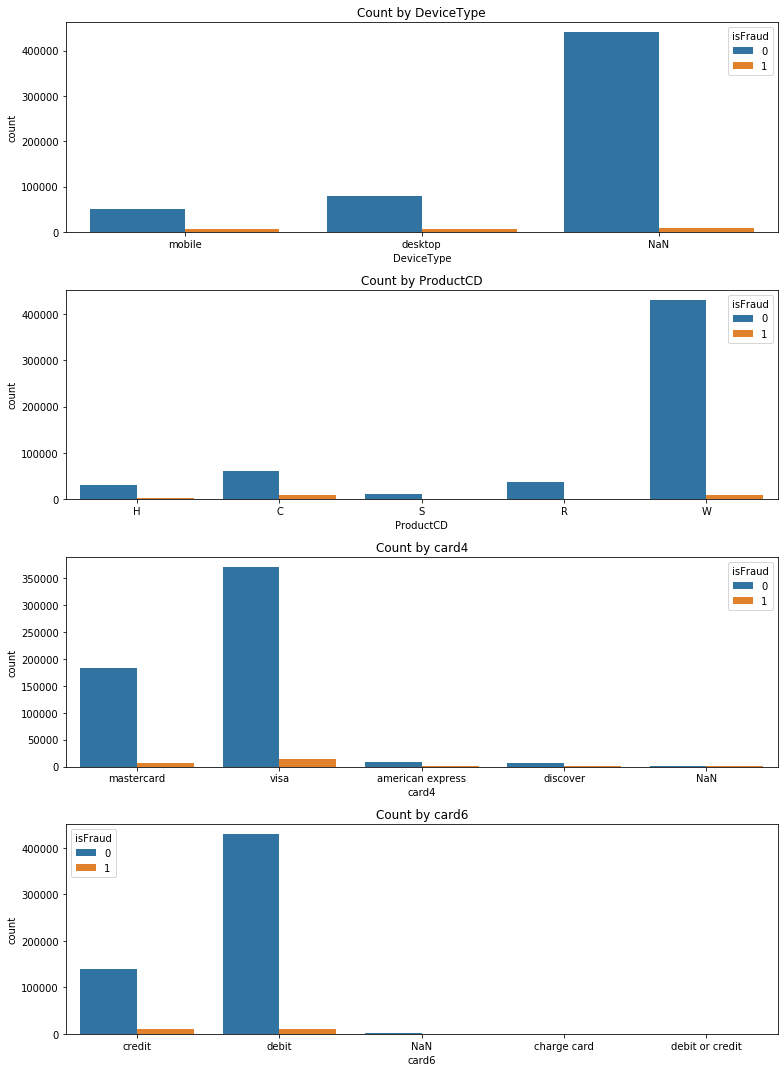

In [14]:
cols = ['DeviceType', 'ProductCD', 'card4', 'card6']
plt.figure(figsize=(11, 15))
for i, col in enumerate(cols):
    plt.subplot(len(cols), 1, i+1)
    sns.countplot(x=col,  hue='isFraud', data=train_merge)
    plt.title('Count by '+str(col))
    plt.tight_layout()

#### Distribution of TransactionAmt by isFraud

C:\Miniconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


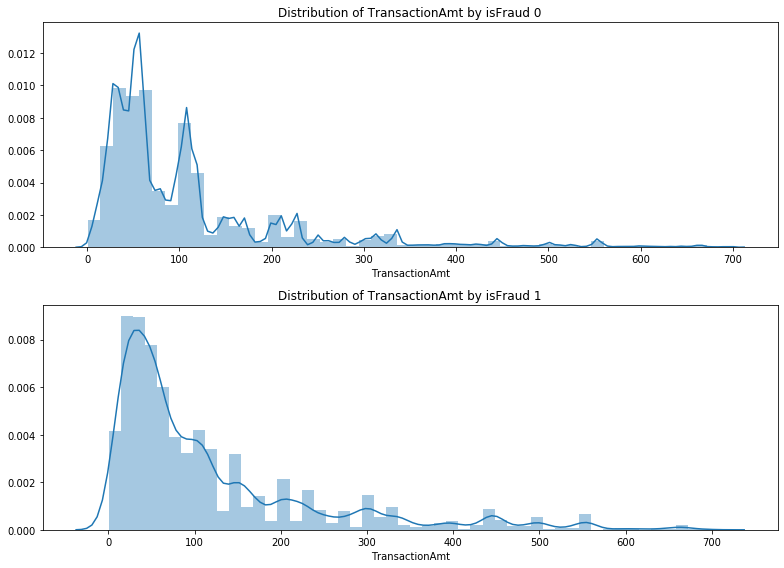

In [15]:
# Distribution of TransactionAmt by isFraud
plt.figure(figsize=(11, 8))
for i in [0, 1]:
    plt.subplot(2,1, i+1)
    sns.distplot(train_merge[train_merge['isFraud'] == i][train_merge['TransactionAmt'] <=700]['TransactionAmt'])
    plt.title('Distribution of TransactionAmt by isFraud '+str(i))
    plt.tight_layout()

#### Distribution of TransactionAmt by DeviceType

C:\Miniconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


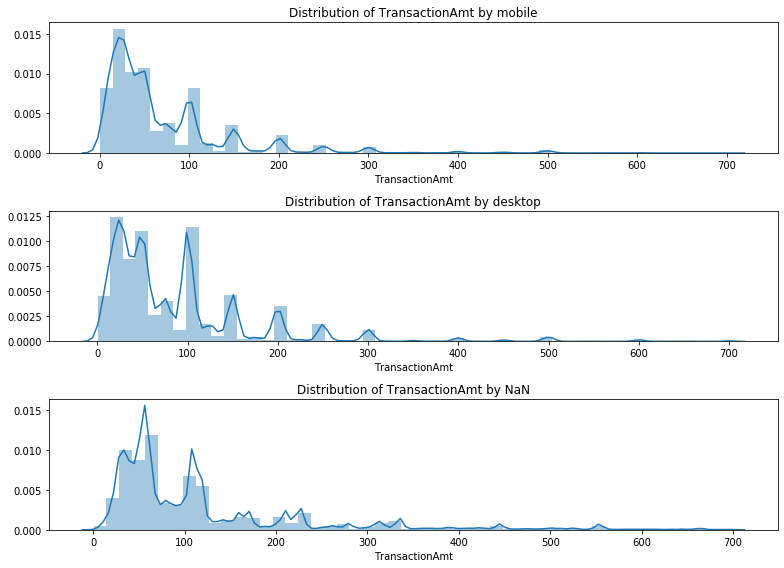

In [16]:
# Distribution of TransactionAmt by DeviceType
devicetype = train_merge['DeviceType'].unique()
plt.figure(figsize=(11, 8))
for i, device in enumerate(devicetype):
    plt.subplot(len(devicetype), 1, i+1)
    sns.distplot(train_merge[train_merge['DeviceType'] == device][train_merge['TransactionAmt'] <=700]['TransactionAmt'])
    plt.title('Distribution of TransactionAmt by '+str(device))
    plt.tight_layout()

C:\Miniconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


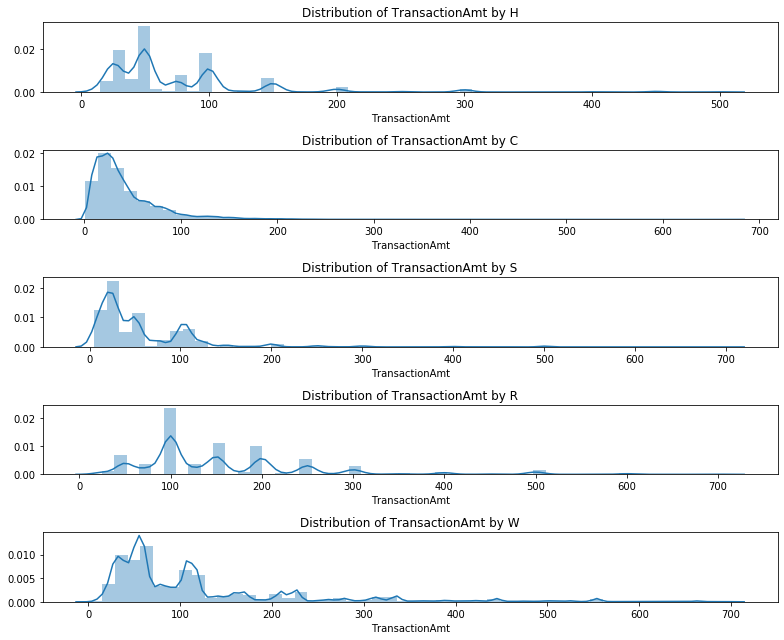

In [17]:
productcd = train_merge['ProductCD'].unique()
plt.figure(figsize=(11, 9))
for i, cd in enumerate(productcd):
    plt.subplot(len(productcd), 1, i+1)
    sns.distplot(train_merge[train_merge['ProductCD']==cd][train_merge['TransactionAmt'] <=700]['TransactionAmt'])
    plt.title('Distribution of TransactionAmt by '+str(cd))
    plt.tight_layout()

## Data Preprocessing

#### Data Simplication
- mobile os / browers / email domain

In [18]:
# unique한 특성이 너무 많아 데이터 단순화 필요 
print('id_30 : {}'.format(train_merge['id_30'].unique())+'\n')
print('id_31 : {}'.format(train_merge['id_31'].unique())+'\n')
print('P_emaildomain : {}'.format(train_merge['P_emaildomain'].unique())+'\n')
print('R_emaildomain : {}'.format(train_merge['R_emaildomain'].unique())+'\n')

id_30 : ['Android 7.0' 'iOS 11.1.2' 'NaN' 'Mac OS X 10_11_6' 'Windows 10'
 'Android' 'Linux' 'iOS 11.0.3' 'Mac OS X 10_7_5' 'Mac OS X 10_12_6'
 'Mac OS X 10_13_1' 'iOS 11.1.0' 'Mac OS X 10_9_5' 'Windows 7'
 'Windows 8.1' 'Mac' 'iOS 10.3.3' 'Mac OS X 10.12' 'Mac OS X 10_10_5'
 'Mac OS X 10_11_5' 'iOS 9.3.5' 'Android 5.1.1' 'Android 7.1.1'
 'Android 6.0' 'iOS 10.3.1' 'Mac OS X 10.9' 'iOS 11.1.1' 'Windows Vista'
 'iOS 10.3.2' 'iOS 11.0.2' 'Mac OS X 10.11' 'Android 8.0.0' 'iOS 10.2.0'
 'iOS 10.2.1' 'iOS 11.0.0' 'Mac OS X 10.10' 'Mac OS X 10_12_3'
 'Mac OS X 10_12' 'Android 6.0.1' 'iOS' 'Mac OS X 10.13'
 'Mac OS X 10_12_5' 'Mac OS X 10_8_5' 'iOS 11.0.1' 'iOS 10.0.2'
 'Android 5.0.2' 'Windows XP' 'iOS 11.2.0' 'Mac OS X 10.6' 'Windows 8'
 'Mac OS X 10_6_8' 'Mac OS X 10_11_4' 'Mac OS X 10_12_1' 'iOS 10.1.1'
 'Mac OS X 10_11_3' 'Mac OS X 10_12_4' 'Mac OS X 10_13_2' 'Android 4.4.2'
 'Mac OS X 10_12_2' 'Android 5.0' 'func' 'Android 7.1.2' 'Android 8.1.0'
 'other' 'Mac OS X 10_13_3' 'iOS 11.2.1' '

In [19]:
def simplify_categorical(data):
    mobile_os = [i.split(' ')[0] for i in data['id_30']]
    browser = []
    for i in data['id_31']:
        if i.split(' ')[0] == 'mobile' and len(i.split(' ')) > 1: # ex. mobile safari 10.0, mobile safari generic, ...
            browser.append(i.split(' ')[1])
        elif i.split('/')[0] == 'Samsung':    # ex. Samsung/SM-G532M, Samsung/SCH, Samsung/SM-G531H,
            browser.append('samsung')
        elif i.split('/')[0] == 'Microsoft':  # ex. Microsoft/Windows
            browser.append('ie')
        elif i.split('/')[0] == 'Mozilla':    # ex. Mozilla/Firefox
            browser.append('firefox')
        elif i.split('/')[0] == 'Generic':    # ex. Generic/Android
            browser.append('android')
        elif len(i.split(' ')) >= 1:          # ex. edge 14.0, android brower 4.0, Chrome 63.0 for Android, ...
            browser.append(i.split(' ')[0])
        else:
            browser.append(i)                  # android, chrome, edge, google, le, ...
    p_emaildomain = [i.split('.')[0] for i in data['P_emaildomain']]
    r_emaildomain = [i.split('.')[0] for i in data['R_emaildomain']]
    
    data['id_30'] = [i.lower() for i in mobile_os]
    data['id_31'] = [i.lower() for i in browser]
    data['P_emaildomain'] = [i.lower() for i in p_emaildomain]
    data['R_emaildomain'] = [i.lower() for i in r_emaildomain]
    
    return data

train = simplify_categorical(train_merge)
train_target = train['isFraud']
train = train.drop('isFraud', axis=1)
test = simplify_categorical(test_merge)

del train_merge, test_merge

In [20]:
print('id_30 : {}'.format(train['id_30'].unique())+'\n')
print('id_31 : {}'.format(train['id_31'].unique())+'\n')
print('P_emaildomain : {}'.format(train['P_emaildomain'].unique())+'\n')
print('R_emaildomain : {}'.format(train['R_emaildomain'].unique())+'\n')

id_30 : ['android' 'ios' 'nan' 'mac' 'windows' 'linux' 'func' 'other']

id_31 : ['samsung' 'safari' 'chrome' 'nan' 'edge' 'firefox' 'ie' 'other' 'android'
 'opera' 'mobile' 'aol' 'silk' 'waterfox' 'nokia/lumia' 'puffin'
 'cyberfox' 'zte/blade' 'palemoon' 'maxthon' 'line' 'lg/k-200' 'iron'
 'blu/dash' 'seamonkey' 'm4tel/m4' 'comodo' 'lanix/ilium' 'chromium'
 'inco/minion' 'cherry' 'icedragon' 'google' 'facebook']

P_emaildomain : ['gmail' 'anonymous' 'hotmail' 'aol' 'yahoo' 'nan' 'outlook' 'charter'
 'comcast' 'optonline' 'embarqmail' 'live' 'icloud' 'juno' 'att' 'msn'
 'cox' 'servicios-ta' 'me' 'verizon' 'bellsouth' 'sbcglobal' 'gmx' 'mail'
 'frontier' 'frontiernet' 'suddenlink' 'roadrunner' 'mac' 'earthlink'
 'web' 'twc' 'ymail' 'windstream' 'rocketmail' 'cfl' 'q' 'prodigy'
 'netzero' 'cableone' 'aim' 'ptd' 'centurylink' 'sc' 'protonmail']

R_emaildomain : ['nan' 'gmail' 'hotmail' 'outlook' 'anonymous' 'charter' 'comcast' 'live'
 'icloud' 'yahoo' 'aol' 'juno' 'att' 'verizon' 'bellsout

#### Label Encoding

In [21]:
# LabelEncoding 
categorical_features = list(object_cols)

for col in categorical_features:
    le = LabelEncoder()
    le.fit(list(train[col].values) + list(test[col].values))
    train[col] = le.transform(list(train[col].values))
    test[col] = le.transform(list(test[col].values))

#### Corrleations

In [22]:
# train_corr = train[:50000].copy()
# train_corr['isFraud'] = train_target.copy()

# corrmat = train_corr.corr()
# top_corr_features = corrmat.index[abs(corrmat['isFraud']) >= 0.10]
# # top_corr_features
# plt.figure(figsize=(13,10))
# sns.heatmap(train_corr[top_corr_features].corr(), annot=False, cmap="RdYlGn")
# plt.title('Variable Correlations')
# plt.show()

#### Z-Score Standardization

In [23]:
train = train.drop('TransactionID', axis=1)
test_tid = test['TransactionID']
test = test.drop('TransactionID', axis=1)

In [24]:
# Standardization
train_scale_ = train.drop(categorical_features, axis=1)
test_scale_ = test.drop(categorical_features, axis=1)

# z = (x - u) / s
train_scale = (train_scale_ - train_scale_.mean()) / train_scale_.std()
test_scale = (test_scale_ - train_scale_.mean()) / train_scale_.std()

In [25]:
train[train_scale.columns] = train_scale
test[test_scale.columns] = test_scale

#### Adding PCA variables

In [26]:
pca = PCA(n_components=3)
pca.fit(train)
pca_train = pca.transform(train)
pca_test = pca.transform(test)

In [27]:
train['pca_col1'] = pca_train[:, 0]
train['pca_col2'] = pca_train[:, 1]
train['pca_col3'] = pca_train[:, 2]

test['pca_col1'] = pca_test[:, 0]
test['pca_col2'] = pca_test[:, 1]
test['pca_col3'] = pca_test[:, 2]

In [28]:
train.columns

Index(['id_01', 'id_02', 'id_05', 'id_06', 'id_11', 'id_12', 'id_15', 'id_17',
       'id_19', 'id_20',
       ...
       'V315', 'V316', 'V317', 'V318', 'V319', 'V320', 'V321', 'pca_col1',
       'pca_col2', 'pca_col3'],
      dtype='object', length=313)

## LightGBM model

In [29]:
# Split train set / valid set
x_train, x_val, y_train, y_val = train_test_split(train, train_target, test_size=0.3, random_state=42)

In [33]:
# LightGBM
lgb_train = lgb.Dataset(x_train, y_train, categorical_feature=categorical_features)
lgb_val = lgb.Dataset(x_val, y_val, categorical_feature=categorical_features)

# parameters
params = {
    'objective':'binary',
    'boosting_type': 'gbdt',
    'max_depth': -1,
    'learning_rate': 0.03,
    'num_leaves': 500,        # number of leaves in full tree
    'feature_fraction':0.7,   # selected parameters ratio in each iteration for building trees
    'bagging_fraction':0.8,   # specifies the fraction of data to be used for each iteration
    'bagging_seed':11,        # random seed for bagging
    'n_jobs':-1,
    'verbosity': -1
}

# Training
lgb_model = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_val],
                     num_boost_round=3000,
                     early_stopping_rounds=500,
                     verbose_eval=100)

C:\Miniconda3\lib\site-packages\lightgbm\basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's binary_logloss: 0.0433287	valid_1's binary_logloss: 0.0662101
[200]	training's binary_logloss: 0.0236987	valid_1's binary_logloss: 0.0558402
[300]	training's binary_logloss: 0.0148734	valid_1's binary_logloss: 0.0523366
[400]	training's binary_logloss: 0.00990411	valid_1's binary_logloss: 0.0508125
[500]	training's binary_logloss: 0.00679783	valid_1's binary_logloss: 0.050581
[600]	training's binary_logloss: 0.00472351	valid_1's binary_logloss: 0.0509746
[700]	training's binary_logloss: 0.00333397	valid_1's binary_logloss: 0.0519237
[800]	training's binary_logloss: 0.00234255	valid_1's binary_logloss: 0.0531545
[900]	training's binary_logloss: 0.00166069	valid_1's binary_logloss: 0.0546412
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.00764256	valid_1's binary_logloss: 0.050517


In [34]:
val_preds_lgb = [1 if i>=0.5 else 0 for i in lgb_model.predict(x_val)]

print('Accuracy : {:.2f}'.format(accuracy_score(val_preds_lgb, y_val)))
print('Recall : {:.2f}'.format(recall_score(val_preds_lgb, y_val)))
print(classification_report(val_preds_lgb, y_val))

Accuracy : 0.99
Recall : 0.96
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    173257
           1       0.61      0.96      0.75      3905

    accuracy                           0.99    177162
   macro avg       0.80      0.97      0.87    177162
weighted avg       0.99      0.99      0.99    177162



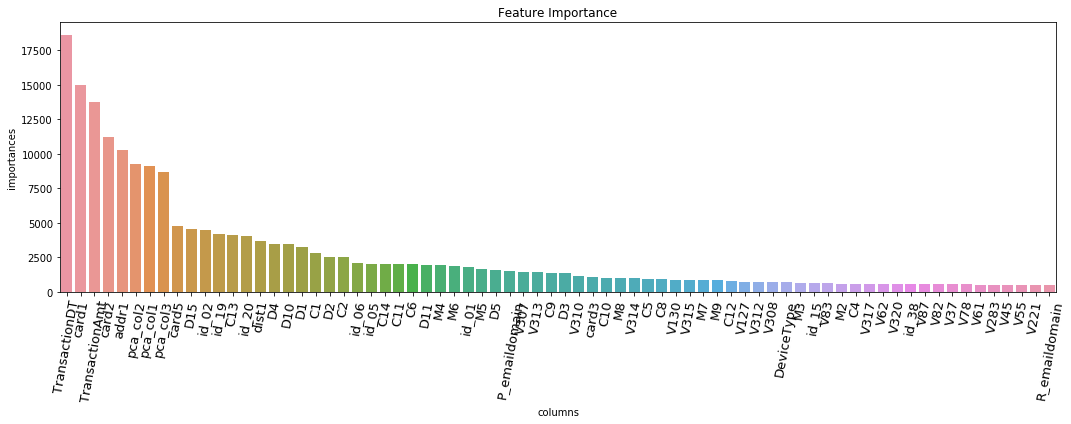

In [35]:
# feature importances
feature_importance = lgb_model.feature_importance()
df_fi = pd.DataFrame({'columns':x_train.columns, 'importances':feature_importance})
df_fi = df_fi[df_fi['importances'] > 500].sort_values(by=['importances'], ascending=False)

fig = plt.figure(figsize=(15, 6))
ax = sns.barplot(df_fi['columns'], df_fi['importances'])
ax.set_xticklabels(df_fi['columns'], rotation=80, fontsize=13)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

## Save Prediction of test to *.csv

In [36]:
test_preds = lgb_model.predict(test)

In [37]:
test_pred_df = pd.DataFrame()
test_pred_df['TransactionID'] = test_tid
test_pred_df['isFraud'] = test_preds

In [38]:
test_pred_df.head(10)

,TransactionID,isFraud
0,3663586,0.027975
1,3663588,0.000173
2,3663597,0.000964
3,3663601,0.005439
4,3663602,0.037521
5,3663622,0.035389
6,3663624,0.026742
7,3663626,0.024641
8,3663629,0.003050
9,3663658,0.000242


In [39]:
test_pred_df.to_csv('lgb_submission.csv', index=False)